# Com S 574 - HW 2
## Miles Lucas

## Problem 2 - Linear Regression

What linear model would be a sutiable choice for modeling the following data

In [16]:
# Imports and Setup
using StatsPlots
using DataFrames
using GLM
using CSV
using RCall

In [2]:
# My custom seaborn-light-esque theme
const deep = [
    "#4C72B0", # Blue
    "#55A868", # Green
    "#C44E52", # Red
    "#DD8452", # Orange
    "#8172B3", # Purple
    "#937860", # Brown
    "#DA8BC3", # Pink
    "#8C8C8C", # Gray
    "#CCB974", # Sand
    "#64B5CD", # Light blue
]
order = [1, 10, 4, 8, 3, 6, 7, 5, 9, 2]
theme(:default;
    palette = deep[order],
    gradient = cgrad(:viridis).colors
)
plotlyjs(markerstrokecolor=false, size=(900, 600));

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/8d504fc888a45b8a35d787765ce25af16a3e6e89-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/8d504fc888a45b8a35d787765ce25af16a3e6e89-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [3]:
filename = "./data/HW2Q2.dat"
data = CSV.read(filename, delim=' ')
delete!(data, 1)
first(data, 10)

┌ Warning: `delete!(df::AbstractDataFrame, cols::Any)` is deprecated, use `deletecols!(df, cols)` instead.
│   caller = top-level scope at In[3]:3
└ @ Core In[3]:3


,x,y
,Float64⍰,Float64⍰
1,-2.0,10.8855
2,-1.98394,11.3154
3,-1.96787,6.12808
4,-1.95181,7.9875
5,-1.93574,7.96264
6,-1.91968,9.3309
7,-1.90361,7.59294
8,-1.88755,4.63816
9,-1.87149,6.75514


Let's start by plotting the raw data.

In [4]:
@df data scatter(:x, :y, 
    label="Data", 
    xlabel="x", 
    ylabel="y",
    markersize=3,
)

WebIO.mount(this.previousSibling,{"props":{},"nodeType":"Scope","type":"node","instanceArgs":{"imports":{"data":[{"name":"Plotly","type":"js","url":"/assetserver/bbe98e4eb5d11d8d46cf8e82c9123d63c26809f1-plotly-latest.min.js"},{"name":null,"type":"js","url":"/assetserver/e2689e07abda7b0c20ce0a2b72ed0349fb639eea-plotly_webio.bundle.js"}],"type":"async_block"},"id":"scope-c903a515-4a93-4bdd-8c9a-65b55b60e99a","handlers":{"_toImage":[(function (options){return this.Plotly.toImage(this.plotElem,options).then((function (data){return WebIO.setval({"name":"image","scope":"scope-c903a515-4a93-4bdd-8c9a-65b55b60e99a","id":"ob_05","type":"observable"},data)}))})],"__get_gd_contents":[(function (prop){prop=="data" ? (WebIO.setval({"name":"__gd_contents","scope":"scope-c903a515-4a93-4bdd-8c9a-65b55b60e99a","id":"ob_06","type":"observable"},this.plotElem.data)) : undefined; return prop=="layout" ? (WebIO.setval({"name":"__gd_contents","scope":"scope-c903a515-4a93-4bdd-8c9a-65b55b60e99a","id":"ob_06","type":"observable"},this.plotElem.layout)) : undefined})],"_promises":{"importsLoaded":[(function (Plotly){var gd=this.dom.querySelector("#plot-a6cf2287-2491-4ed8-b4c2-291e0393d40a"); this.plotElem=gd; this.Plotly=Plotly; (window.Blink!==undefined) ? (gd.style.width="100%", gd.style.height="100vh", gd.style.marginLeft="0%", gd.style.marginTop="0vh") : undefined; window.onresize=(function (){return Plotly.Plots.resize(gd)}); Plotly.newPlot(gd,[],{"margin":{"l":50,"b":50,"r":50,"t":60}},{}); gd.on("plotly_hover",(function (data){var filtered_data=WebIO.PlotlyCommands.filterEventData(gd,data,"hover"); return !(filtered_data.isnil) ? (WebIO.setval({"name":"hover","scope":"scope-c903a515-4a93-4bdd-8c9a-65b55b60e99a","id":"ob_01","type":"observable"},filtered_data.out)) : undefined})); gd.on("plotly_unhover",(function (){return WebIO.setval({"name":"hover","scope":"scope-c903a515-4a93-4bdd-8c9a-65b55b60e99a","id":"ob_01","type":"observable"},{})})); gd.on("plotly_selected",(function (data){var filtered_data=WebIO.PlotlyCommands.filterEventData(gd,data,"selected"); return !(filtered_data.isnil) ? (WebIO.setval({"name":"selected","scope":"scope-c903a515-4a93-4bdd-8c9a-65b55b60e99a","id":"ob_02","type":"observable"},filtered_data.out)) : undefined})); gd.on("plotly_deselect",(function (){return WebIO.setval({"name":"selected","scope":"scope-c903a515-4a93-4bdd-8c9a-65b55b60e99a","id":"ob_02","type":"observable"},{})})); gd.on("plotly_relayout",(function (data){var filtered_data=WebIO.PlotlyCommands.filterEventData(gd,data,"relayout"); return !(filtered_data.isnil) ? (WebIO.setval({"name":"relayout","scope":"scope-c903a515-4a93-4bdd-8c9a-65b55b60e99a","id":"ob_04","type":"observable"},filtered_data.out)) : undefined})); return gd.on("plotly_click",(function (data){var filtered_data=WebIO.PlotlyCommands.filterEventData(gd,data,"click"); return !(filtered_data.isnil) ? (WebIO.setval({"name":"click","scope":"scope-c903a515-4a93-4bdd-8c9a-65b55b60e99a","id":"ob_03","type":"observable"},filtered_data.out)) : undefined}))})]},"_downloadImage":[(function (options){return this.Plotly.downloadImage(this.plotElem,options)})],"_commands":[(function (args){var fn=args.shift(); var elem=this.plotElem; var Plotly=this.Plotly; args.unshift(elem); return Plotly[fn].apply(this,args)})]},"systemjs_options":null,"observables":{"_toImage":{"sync":false,"id":"ob_08","value":{}},"hover":{"sync":false,"id":"ob_01","value":{}},"selected":{"sync":false,"id":"ob_02","value":{}},"__gd_contents":{"sync":false,"id":"ob_06","value":{}},"click":{"sync":false,"id":"ob_03","value":{}},"image":{"sync":true,"id":"ob_05","value":""},"__get_gd_contents":{"sync":false,"id":"ob_10","value":""},"_downloadImage":{"sync":false,"id":"ob_09","value":{}},"relayout":{"sync":false,"id":"ob_04","value":{}},"_commands":{"sync":false,"id":"ob_07","value":["relayout",{"showlegend":true,"xaxis":{"showticklabels":true,"gridwidth":0.5,"tickvals":[-2.0,-1.0,0.0,1.0,2.0],"visible":true,"ticks":"inside","range"

The first thing I notice is that the data does not look linear. Looks are not the whole story though, so I will proceed doing the appropriate tests for my report.

### Doing the regression

I am using the GLM.jl package in Julia which allows very simple linear modelling (extremely similar to R). In the following I use a standard, ordinary least-squares model

\begin{equation}
    Y = \beta_0 + \beta_1 X + e_i
\end{equation}

Note that I am suppressing the output because I need to make some simple checks to see if doing OLS is even appropriate

In [18]:
ols = lm(@formula(y ~ 1 + x), data)

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x

Coefficients:
             Estimate Std.Error t value Pr(>|t|)
(Intercept)   8.03213   0.25155 31.9305   <1e-89
x             2.87531  0.216979 13.2516   <1e-29


 ---
 Let's see what this looks like

In [19]:
p1 = @df data scatter(:x, :y, 
    label="Data",
    xlabel="x",
    ylabel="y",
    markersize=2,
)

plot!(data.x, predict(ols), 
    lw=2,
    label="QLS"
)
p2 = scatter(data.x, residuals(ols), 
    ms=2, 
    color=:black, 
    ylabel="resid.", 
    label="", 
    xlabel="x",
    yguide_position=:right,
)

hline!([0], 
    ls=:dash,
    c=:black, 
    label="")

lags = 0:50
p3 = bar(lags, autocor(residuals(ols), lags),
    xlabel="lag",
    ylabel="acf",
    label="",
    yguide_position=:right,
)

l = @layout [a{0.65w} [b; c]]
plot(p1, p2, p3, layout=l)

UndefVarError: UndefVarError: predict not defined

### Testing our initial assumptions

In order to perform ordinary least squares, I need to prove these assumptions are valid:

1. $\mathbb{E}(e_i)=0$
2. $\mathbb{V}(e_i)=\sigma^2_e$ (errors are constant, or homoscedastic)
3. $\text{cov}(e_i, e_j)=0 \quad \forall i\neq j$ (errors are uncorrelated)

I assert these assumptions by performing the following tests with significance level $\alpha$=0.05:

#### Run's Test

This will test if our errors are homoscedastic. I take a null hypothesis that the errors are homoscedastic with an alternative hypothesis that the errors are not homoscedastic. I call the `runs.test` from R, which works fine in Julia because Julia is a great programming language

In [7]:
@rlibrary lawstat
R"lawstat::runs.test($(residuals(ols)))"

RObject{VecSxp}

	Runs Test - Two sided

data:  `#JL`$`(residuals(ols))`
Standardized Runs Statistic = -10.013, p-value < 2.2e-16



Uh oh. The output of the runs test out my significance level means we reject the null-hypothesis. This implies that our errors are not random and we cannot trust our ordinary least-squares fit.

In [8]:
@rlibrary 

LoadError: MethodError: no method matching @rlibrary(::LineNumberNode, ::Module)
Closest candidates are:
  @rlibrary(::LineNumberNode, ::Module, !Matched::Any) at C:\Users\drumm\.julia\packages\RCall\29zDq\src\namespaces.jl:93

### Testing a Quadratic Model

Given the poor performance of such a model, for fun, let's see what a quadratic relationship would look like.

In [9]:
# Define our least squares loss function
function quad_loss(coeffs)
    y_pred = coeffs[1] .+ coeffs[2] * data.x .+ coeffs[3] * data.x .^ 2
    R = y_pred .- data.y
    return sum(R.^2)
end

using Optim

res = optimize(quad_loss, [1., 1., 1.], BFGS(), autodiff=:forward)

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [1.0,1.0,1.0]
 * Minimizer: [4.290503934203045,2.8753099131414066, ...]
 * Minimum: 1.123384e+03
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 1.25e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 1.66e-01 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 3.12e-12 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 7
 * Gradient Calls: 7

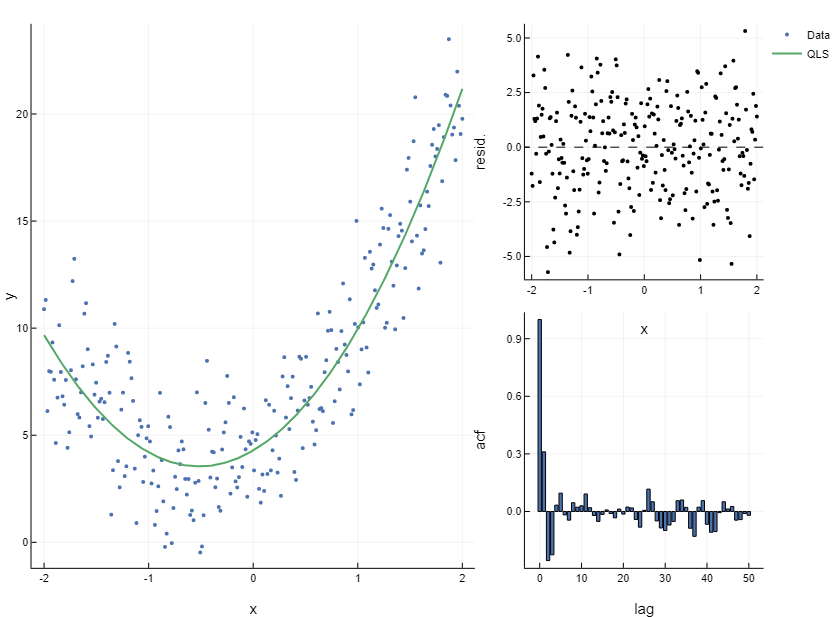

In [10]:
fit = res.minimizer[1] .+ res.minimizer[2] * data.x .+ res.minimizer[3] * data.x .^ 2
resids = fit - data.y

p1 = @df data scatter(:x, :y, 
    label="Data",
    xlabel="x",
    ylabel="y",
    markersize=2,
)

plot!(data.x, fit, 
    lw=2,
    label="QLS"
)
p2 = scatter(data.x, resids, 
    ms=2, 
    color=:black, 
    ylabel="resid.", 
    label="", 
    xlabel="x",
    yguide_position=:right,
)

hline!([0], 
    ls=:dash,
    c=:black, 
    label="")

lags = 0:50
p3 = bar(lags, autocor(resids, lags),
    xlabel="lag",
    ylabel="acf",
    label="",
    yguide_position=:right,
)

l = @layout [a{0.65w} [b; c]]
plot(p1, p2, p3, layout=l)

In [11]:
@rlibrary lawstat
R"lawstat::runs.test($resids)"

RObject{VecSxp}

	Runs Test - Two sided

data:  `#JL`$resids
Standardized Runs Statistic = -3.5489, p-value = 0.0003869

